<a href="https://colab.research.google.com/github/Laura-Tovo/Ubiquity/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Hypothesis 1: More cars = worse air quality

Loading data

In [52]:
# Traffic data (Jan-)
path_traffic = 'scats_detector_volume_jan-jun-2020.csv'

traffic = pd.read_csv(path_traffic)

# Detailed air quality data (April 2022)
path_air = 'AirView_DublinCity_Measurements_ugm3.csv'
air = pd.read_csv(path_air)

The air quality dataset contains high-resolution measurements (1 second intervals)
from April 2022. The traffic dataset is from November 2019.
Therefore, the datasets DO NOT overlap in time.
This analysis remains exploratory only. It does not support causal conclusions,
but can help investigate general spatial or trend relationships.

Cleaning and preparing traffic data

Processing the air quality data

Attempt to match by date (note: different years)
-----------------------------
We perform a merge only to illustrate potential correlation visually
but dates do not actually match — this is a methodological limitation.

Exploratory analysis

In [53]:
# Weekly vehicle volume from SCATS dataset (Jan–Jun 2020)

# Build full date from Year, Month, Day
traffic['Date'] = pd.to_datetime(traffic[['Year', 'Month', 'Day']])

# Filter only the first 6 months (if needed)
traffic = traffic[(traffic['Date'] >= '2020-01-01') & (traffic['Date'] <= '2020-06-30')]

# Remove invalid counts
traffic = traffic.dropna(subset=['SumOfSumVolume'])
traffic['SumOfSumVolume'] = pd.to_numeric(traffic['SumOfSumVolume'], errors='coerce')

# Sum all volumes per day (across all sites)
traffic_daily = traffic.groupby('Date')['SumOfSumVolume'].sum().reset_index()
traffic_daily.rename(columns={'SumOfSumVolume': 'TotalVehicles'}, inplace=True)

# Add week number (ISO calendar) for grouping
traffic_daily['Week'] = traffic_daily['Date'].dt.isocalendar().week

# Aggregate weekly total (or mean) vehicle volume
traffic_weekly = (
    traffic_daily.groupby('Week')['TotalVehicles']
    .mean()  # or .sum() if you want total volume per week instead of average per day
    .reset_index()
)

# Preview weekly traffic
#traffic_weekly

In [54]:
# Load full air quality dataset
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
cols = ['gps_timestamp'] + pollutants

air_2 = pd.read_csv(path_air, usecols=cols, parse_dates=['gps_timestamp'], low_memory=False)

# Filter for April to September 2022
#air_2 = air_2[(air_2['gps_timestamp'] >= '2022-04-01') & (air['gps_timestamp'] <= '2022-09-30')]

# Remove negative values
for col in pollutants:
   air_2 = air_2[air_2[col] >= 0]

# Create week number
air_2['Week'] = air_2['gps_timestamp'].dt.isocalendar().week

# Aggregate weekly averages for each pollutant
air_weekly = air_2.groupby('Week')[pollutants].mean().reset_index()


In [55]:
air_2.head(5)

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14
22,2022-04-07 14:56:58+00:00,33.591,3.622,64.880,0.302,788.260,7.781,14
27,2022-04-07 14:57:03+00:00,3.791,2.744,61.771,0.295,811.146,7.031,14
44,2022-04-07 14:57:20+00:00,57.616,17.058,55.778,0.306,783.987,7.936,14


# Air quality DataBase

In [56]:
def calculateMean(data, columns):
    meanData = []
    for col in columns:
        meanData.append(data[col].mean())
    return meanData

In [58]:
air_2.head(5) # The air database is updated every few seconds, so for a better analysis we devide that

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14
22,2022-04-07 14:56:58+00:00,33.591,3.622,64.880,0.302,788.260,7.781,14
27,2022-04-07 14:57:03+00:00,3.791,2.744,61.771,0.295,811.146,7.031,14
44,2022-04-07 14:57:20+00:00,57.616,17.058,55.778,0.306,783.987,7.936,14


In [161]:
air_ts = air_2.copy() #the data is not sorted by date as it starts on a random date so we have to organize it,creating a copy to not mess the last part of the code

In [164]:
air_ts = air_ts.sort_values('gps_timestamp').reset_index(drop=True)

In [165]:
# adds column hour
air_ts['Hour'] = air_ts['gps_timestamp'].dt.hour
# extract date
air_ts['Day_date'] = air_ts['gps_timestamp'].dt.date
# sequency (1, 2, 3, ...)
air_ts['Day_number'] = (air_ts['Day_date'] != air_ts['Day_date'].shift()).cumsum()
# the time stamp starts on april 7th 2022, a Thursday
air_ts.head(5)

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week,Hour,Day_date,Day_number
0,2021-05-06 12:31:02+00:00,40.546,33.507,38.240,0.321,805.010,2.997,18,12,2021-05-06,1
1,2021-05-06 12:31:05+00:00,18.509,36.554,40.461,0.306,805.227,3.027,18,12,2021-05-06,1
2,2021-05-06 12:49:19+00:00,14.343,34.920,47.564,0.387,823.322,3.516,18,12,2021-05-06,1
3,2021-05-06 12:49:21+00:00,16.713,34.257,46.232,0.357,823.363,4.089,18,12,2021-05-06,1
4,2021-05-06 12:49:41+00:00,38.833,19.110,58.664,0.322,804.591,2.543,18,12,2021-05-06,1


In [166]:
air_ts['gps_timestamp'] = pd.to_datetime(air_ts['gps_timestamp'])

In [167]:
print(sorted(air_ts['Day_date'].unique()))

[datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.date(2021, 5, 17), datetime.date(2021, 5, 18), datetime.date(2021, 5, 19), datetime.date(2021, 5, 24), datetime.date(2021, 5, 25), datetime.date(2021, 5, 26), datetime.date(2021, 5, 27), datetime.date(2021, 5, 31), datetime.date(2021, 6, 1), datetime.date(2021, 6, 2), datetime.date(2021, 6, 3), datetime.date(2021, 6, 4), datetime.date(2021, 6, 8), datetime.date(2021, 6, 9), datetime.date(2021, 6, 10), datetime.date(2021, 6, 11), datetime.date(2021, 6, 14), datetime.date(2021, 6, 15), datetime.date(2021, 6, 16), datetime.date(2021, 6, 17), datetime.date(2021, 6, 18), datetime.date(2021, 6, 21), datetime.date(2021, 6, 22), datetime.date(2021, 6, 23), datetime.date(2021, 6, 24), datetime.date(2021, 6, 25), datetime.date(2021, 6, 28), datetime.date(2021, 6, 29), datetime.date(2021, 6, 30),

Analysing the days, we can see that the data collection skeeps weekends and some times some days of the week, but that still allows for a daily week day analysis

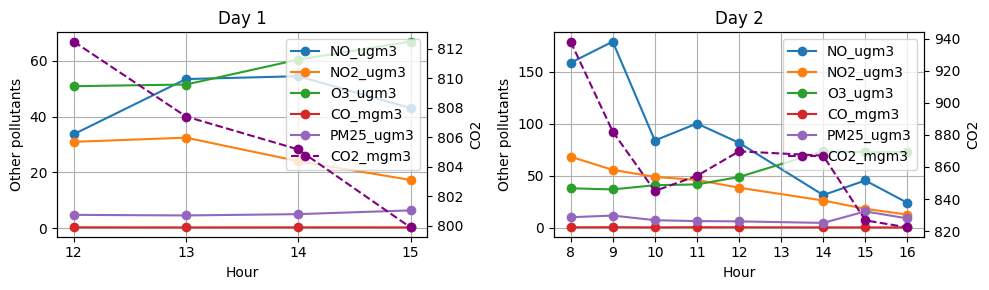

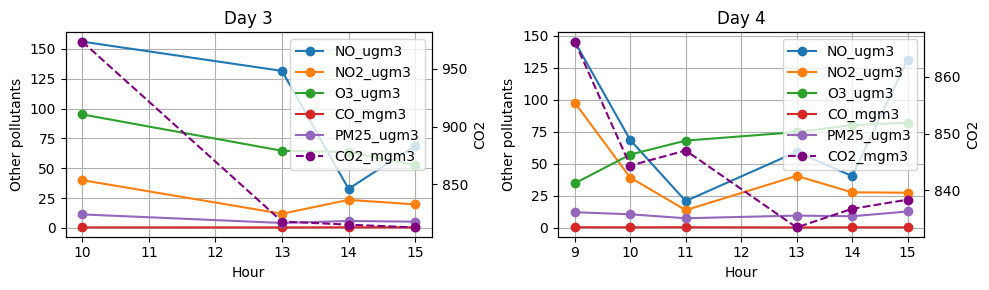

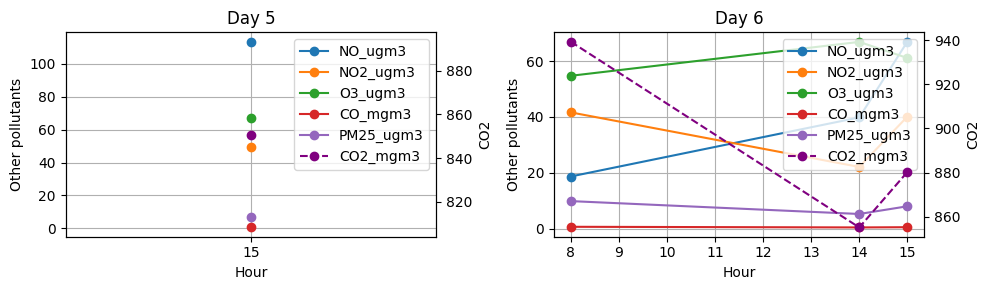

last week


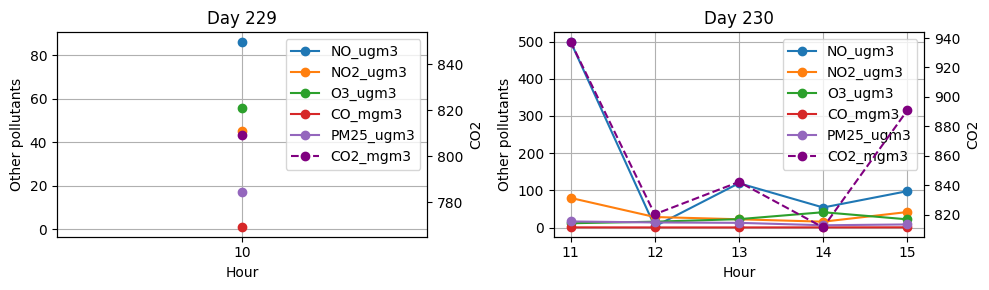

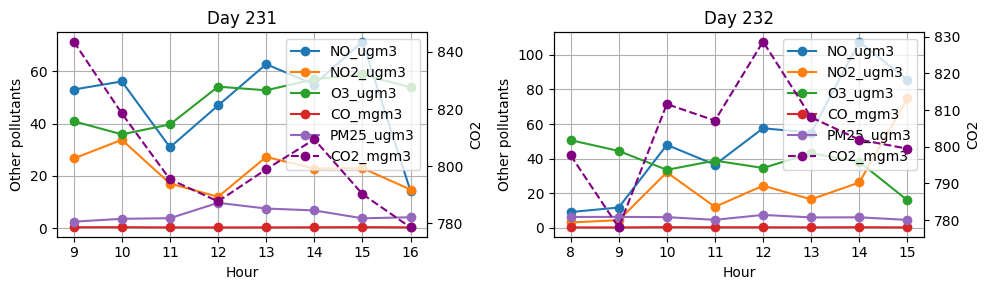

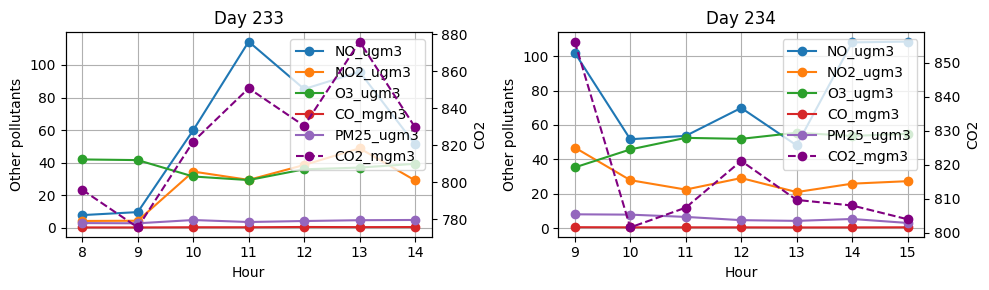

In [175]:
import matplotlib.pyplot as plt

def plot_pollutants_by_hour(air_ts, pollutants, day_numbers):
    # Cria uma figura com N subplots lado a lado
    fig, axes = plt.subplots(1, len(day_numbers), figsize=(5 * len(day_numbers), 3))  # Ajusta o tamanho

    # Garante que axes seja iterável, mesmo com um único subplot
    if len(day_numbers) == 1:
        axes = [axes]

    for ax, day_number in zip(axes, day_numbers):
        df_filtered = air_ts[air_ts['Day_number'] == day_number]
        hourly_means = df_filtered.groupby('Hour')[pollutants].mean().reset_index()

        main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

        # Eixo principal
        for pollutant in main_pollutants:
            ax.plot(hourly_means['Hour'], hourly_means[pollutant], label=pollutant, marker='o')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Other pollutants')
        ax.set_title(f'Day {day_number}')
        ax.grid(True)
        ax.set_xticks(range(0,24))

        # Eixo secundário para CO2
        ax2 = ax.twinx()
        ax2.plot(hourly_means['Hour'], hourly_means['CO2_mgm3'], label='CO2_mgm3', color='purple', marker='o', linestyle='--')
        ax2.set_ylabel('CO2')

        # Combina legendas
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[1,2])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[3,4])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[5,6])
print('last week')
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[229,230])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[231,232])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[233,234])

Understanding the Daily analysis we can see that some days the data was not very well collected so we can try to take those days off of consideration to get a deeper analysis

But looking at the data we can see that the values are very inconsistant throughout the day and that there wasn't much change in air pollution in through the year 2021 - 2022, the transition out of the Covid-19 back into normal

Before getting the mean for the days we need to take of the days with very few data, so we leave the ones that have at least 5 hours of data collection

In [179]:
hours_per_day = air_ts.groupby('Day_number')['Hour'].nunique()
valid_days = hours_per_day[hours_per_day >= 4].index
air_ts_filtered = air_ts[air_ts['Day_number'].isin(valid_days)].reset_index(drop=True)

In [182]:
# This section separates de Air quality database into Hour and Days to make an analysis time based
air_ts_filtered['gps_timestamp'] = pd.to_datetime(air_ts_filtered['gps_timestamp'])
# For the hourly analysis
air_daily = air_ts_filtered.groupby('Day_number')[pollutants].mean().reset_index()

In [193]:
air_daily['Day_block'] = ((air_daily['Day_number'] - air_daily['Day_number'].min()) // 5) + 1
air_5days = air_daily.groupby('Day_block')[pollutants].mean().reset_index()
day_ranges = air_daily.groupby('Day_block')['Day_number'].agg(['min', 'max']).reset_index()
air_5days = pd.merge(air_5days, day_ranges, on='Day_block')

This is hard to visualize given the amount of data, but if we split it into 30 days it is better to visualize

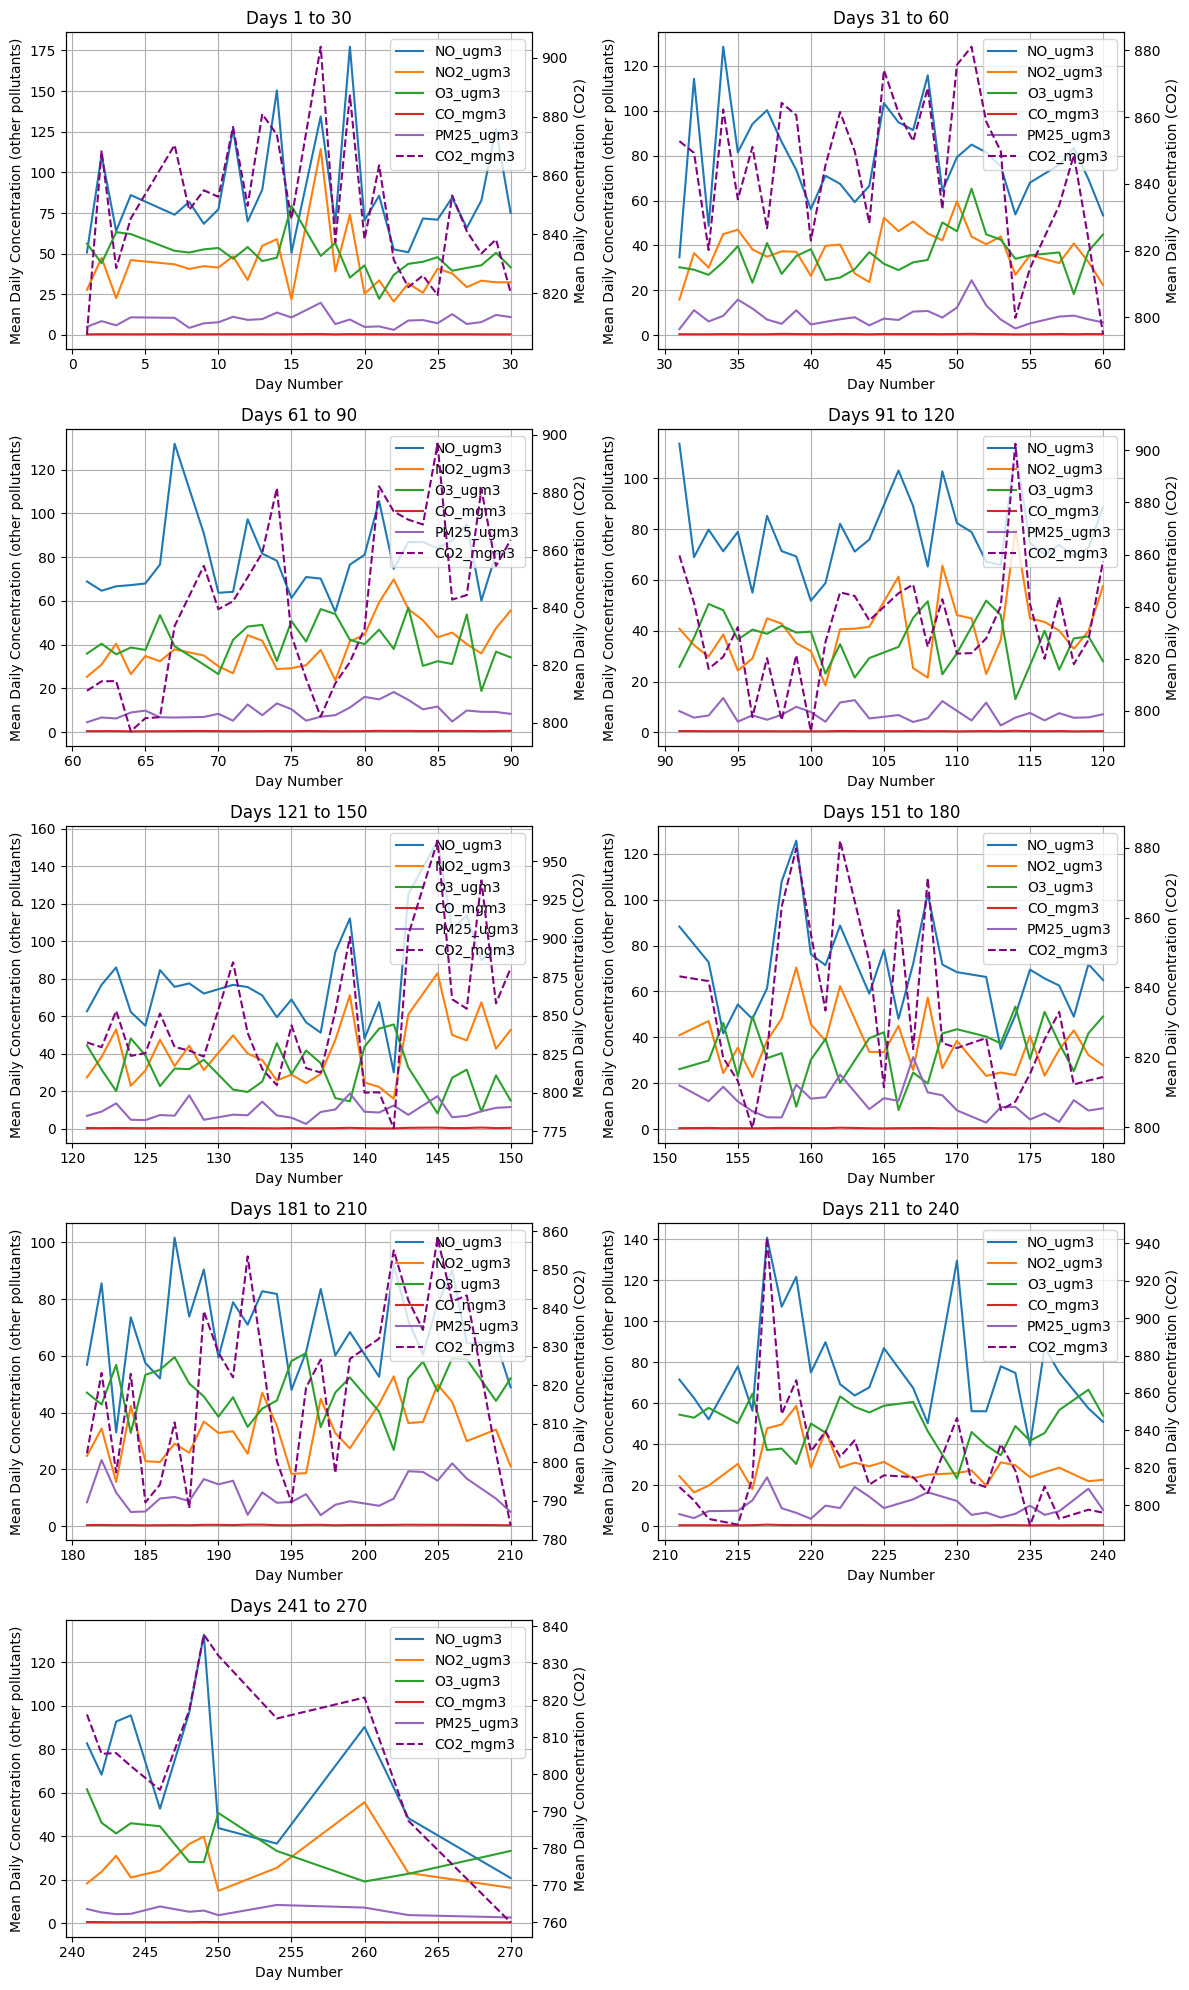

In [190]:
import matplotlib.pyplot as plt
import numpy as np

def plot_daily_pollutants(air_daily, pollutants, day_start, day_end, days_per_plot=20):
    # Filtra os dias dentro do intervalo desejado
    df_filtered = air_daily[(air_daily['Day_number'] >= day_start) & (air_daily['Day_number'] <= day_end)]

    # Define quantos gráficos vai precisar (2 por linha)
    total_days = day_end - day_start + 1
    num_plots = int(np.ceil(total_days / days_per_plot))

    fig, axes = plt.subplots(num_plots // 2 + num_plots % 2, 2, figsize=(12, 4 * (num_plots // 2 + num_plots % 2)))
    axes = axes.flatten()  # Deixa a matriz de eixos como uma lista

    main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

    for i in range(num_plots):
        day_range_start = day_start + i * days_per_plot
        day_range_end = min(day_range_start + days_per_plot - 1, day_end)

        df_chunk = df_filtered[(df_filtered['Day_number'] >= day_range_start) & (df_filtered['Day_number'] <= day_range_end)]

        ax1 = axes[i]

        # Eixo principal
        for pollutant in main_pollutants:
            ax1.plot(df_chunk['Day_number'], df_chunk[pollutant], label=pollutant)
        ax1.set_xlabel('Day Number')
        ax1.set_ylabel('Mean Daily Concentration (other pollutants)')
        ax1.set_title(f'Days {day_range_start} to {day_range_end}')
        ax1.grid(True)

        # Eixo secundário para CO2
        ax2 = ax1.twinx()
        ax2.plot(df_chunk['Day_number'], df_chunk['CO2_mgm3'], label='CO2_mgm3', color='purple', linestyle='--')
        ax2.set_ylabel('Mean Daily Concentration (CO2)')

        # Junta as legendas
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # Remove plots vazios (se o número de plots for ímpar)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
plot_daily_pollutants(air_daily, pollutants, day_start=1, day_end=270, days_per_plot=30)

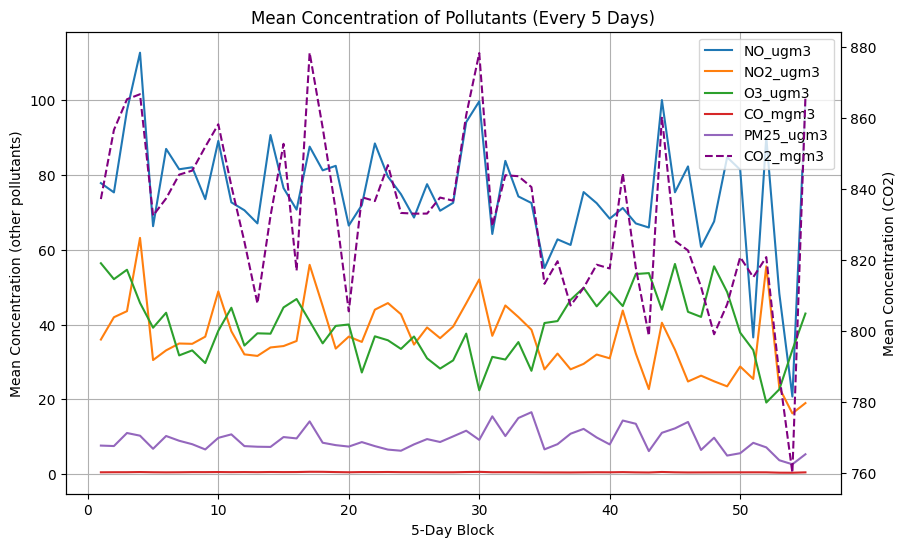

In [195]:
import matplotlib.pyplot as plt

def plot_5day_pollutants(air_5days, pollutants):
    main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

    fig, ax1 = plt.subplots(figsize=(10,6))

    for pollutant in main_pollutants:
        ax1.plot(air_5days['Day_block'], air_5days[pollutant], label=pollutant)
    ax1.set_xlabel('5-Day Block')
    ax1.set_ylabel('Mean Concentration (other pollutants)')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(air_5days['Day_block'], air_5days['CO2_mgm3'], label='CO2_mgm3', color='purple', linestyle='--')
    ax2.set_ylabel('Mean Concentration (CO2)')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Mean Concentration of Pollutants (Every 5 Days)')
    plt.show()

plot_5day_pollutants(air_5days, pollutants)

Seeing this last comparison we can actually see a slight decrease in the concentration of pollutants, with the exeption of O3, that shows that activities in 2021 were already up, or that it just didn't impact the quality of the air being back into action from 2021-2022

# Merge

In [ ]:
# Merge traffic and air quality weekly data
merged = pd.merge(traffic_weekly, air_weekly, on='Week')
# ⚠️ NOTE:
# These datasets refer to different years (2019 and 2022)
# and are only used for exploratory comparison of weekly patterns.
#merged

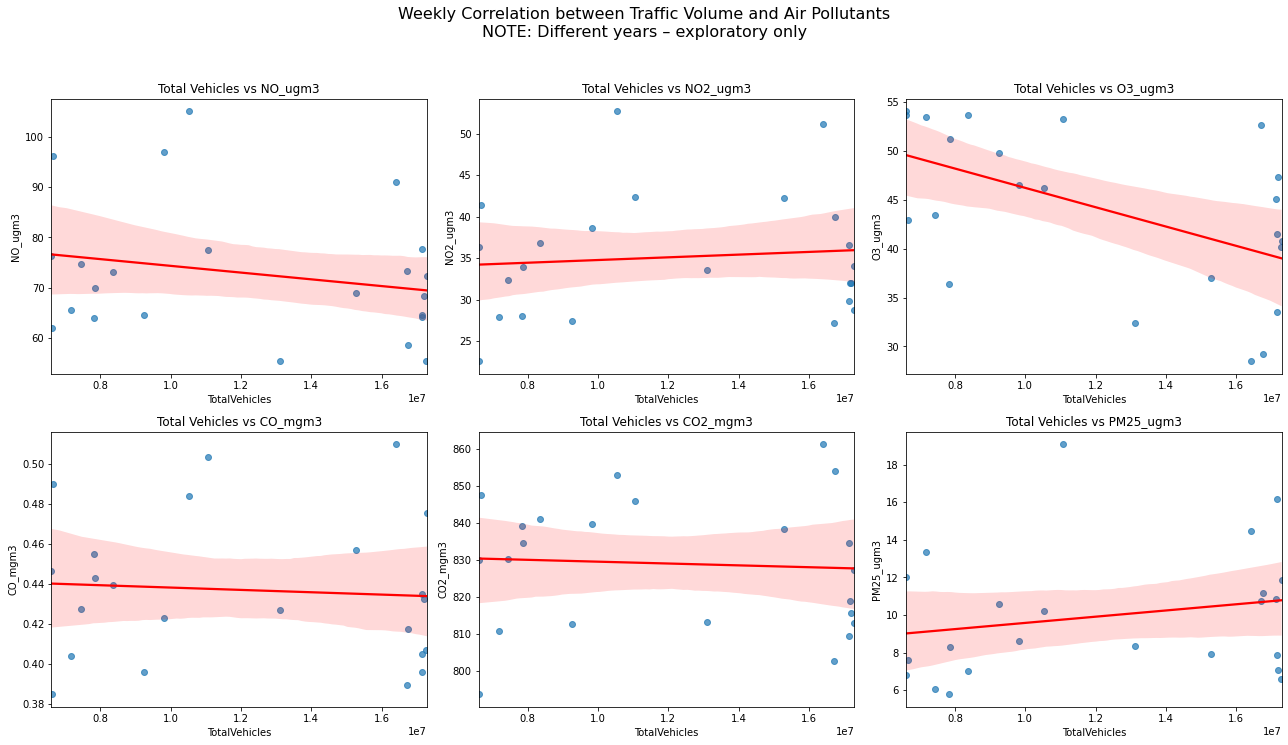

,Week,TotalVehicles,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
Week,1.000000,-0.791746,0.393808,-0.001073,0.575229,0.124587,0.168725,-0.312144
TotalVehicles,-0.791746,1.000000,-0.223842,0.096064,-0.531529,-0.071249,-0.061468,0.214003
NO_ugm3,0.393808,-0.223842,1.000000,0.719246,0.075999,0.612571,0.606762,0.220861
NO2_ugm3,-0.001073,0.096064,0.719246,1.000000,-0.347839,0.796693,0.868288,0.356825
O3_ugm3,0.575229,-0.531529,0.075999,-0.347839,1.000000,-0.251977,-0.407518,-0.012591
CO_mgm3,0.124587,-0.071249,0.612571,0.796693,-0.251977,1.000000,0.797751,0.347098
CO2_mgm3,0.168725,-0.061468,0.606762,0.868288,-0.407518,0.797751,1.000000,0.253380
PM25_ugm3,-0.312144,0.214003,0.220861,0.356825,-0.012591,0.347098,0.253380,1.000000


In [ ]:
# Plot correlation between traffic and each pollutant
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=merged,
        x='TotalVehicles',
        y=pollutant,
        scatter_kws={'alpha': 0.7},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'Total Vehicles vs {pollutant}')

plt.suptitle('Weekly Correlation between Traffic Volume and Air Pollutants\nNOTE: Different years – exploratory only', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

# Show correlation values
merged.corr()


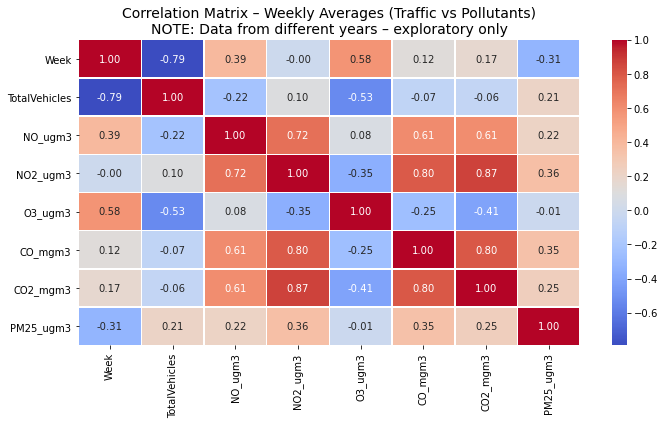

In [ ]:
# Correlation matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix – Weekly Averages (Traffic vs Pollutants)\nNOTE: Data from different years – exploratory only', fontsize=14)
plt.tight_layout()
plt.show()


📊 Interpretation of the Correlation Plots – Hypothesis 1: More Cars = Worse Air Quality
The plots display the weekly correlation between total vehicle volume and the average concentration of each air pollutant.

Each blue dot represents one week of data, combining traffic volumes (from January to June 2020) and air quality measurements (from April to September 2022). The red line indicates the linear trend, and the shaded area represents the confidence interval.

#### 🔍 Pollutant-by-pollutant interpretation:
- NO (Nitric Oxide):
The trend is slightly negative, suggesting that higher traffic volumes are not consistently associated with increased NO levels. This goes against expectations and may reflect data noise or meteorological influences.

- NO₂ (Nitrogen Dioxide):
The trend is almost flat, with a very weak positive slope. NO₂ is typically a key indicator of vehicle emissions, but no strong correlation is observed here.

- O₃ (Ozone):
The plot shows a negative trend. This is expected, as NO reacts with O₃ and tends to reduce its concentration in areas with heavy traffic. This relationship is consistent with real-world chemical behavior.

- CO (Carbon Monoxide):
The trend is nearly flat, indicating no significant correlation with vehicle volume. Weekly CO variations appear to be minor or influenced by other sources.

- CO₂ (Carbon Dioxide):
A very slight negative trend is observed, but with minimal variation. CO₂ is a background gas affected by multiple factors and may not reflect short-term traffic changes.

- PM2.5 (Fine Particulate Matter):
A slightly positive trend appears, which could suggest that traffic contributes to particle emissions. However, the correlation remains weak due to wide dispersion across weeks.



#### 📌 Conclusion:
While some pollutants (such as O₃ and PM2.5) show trends that align with the initial hypothesis (i.e., more cars lead to worse air quality), most relationships are weak or inconsistent.
This may be explained by:

The difference in the year of data collection (2020 for traffic vs. 2022 for air quality);

Meteorological variability and wind dispersion;

The influence of other pollution sources;

Sensor limitations or measurement noise.

These results highlight the importance of using temporally aligned datasets and controlling for external factors when testing environmental hypotheses.



# Hypothesis 2

### Hypothesis 2: Better air quality = more people cycling/walking

In [ ]:
# Load both datasets (adjust paths as needed)
cycle_df = pd.read_csv('../arquivos/cycle-counts-2022.csv', parse_dates=['Time'], dayfirst=True)
pedestrian_df = pd.read_csv('../arquivos/pedestrian-counts-2022.csv', parse_dates=['Time'], dayfirst=True)

# Sum all count columns (excluding Time)
cycle_df['TotalCyclists'] = cycle_df.drop(columns=['Time']).sum(axis=1)
pedestrian_df['TotalPedestrians'] = pedestrian_df.drop(columns=['Time']).sum(axis=1)

# Combine pedestrian and cyclist counts
people_df = pd.DataFrame()
people_df['Time'] = cycle_df['Time']  # assume time columns match
people_df['TotalPeople'] = cycle_df['TotalCyclists'] + pedestrian_df['TotalPedestrians']

# Add ISO week number
people_df['Week'] = people_df['Time'].dt.isocalendar().week

# Weekly average of total people (cycling + walking)
weekly_people = people_df.groupby('Week')['TotalPeople'].mean().reset_index()


Step 2 – Load air quality data and calculate weekly means

In [128]:
weekly_air = air_weekly

merged = pd.merge(weekly_people, weekly_air, on='Week')
merged.head(5)

NameError: name 'weekly_people' is not defined

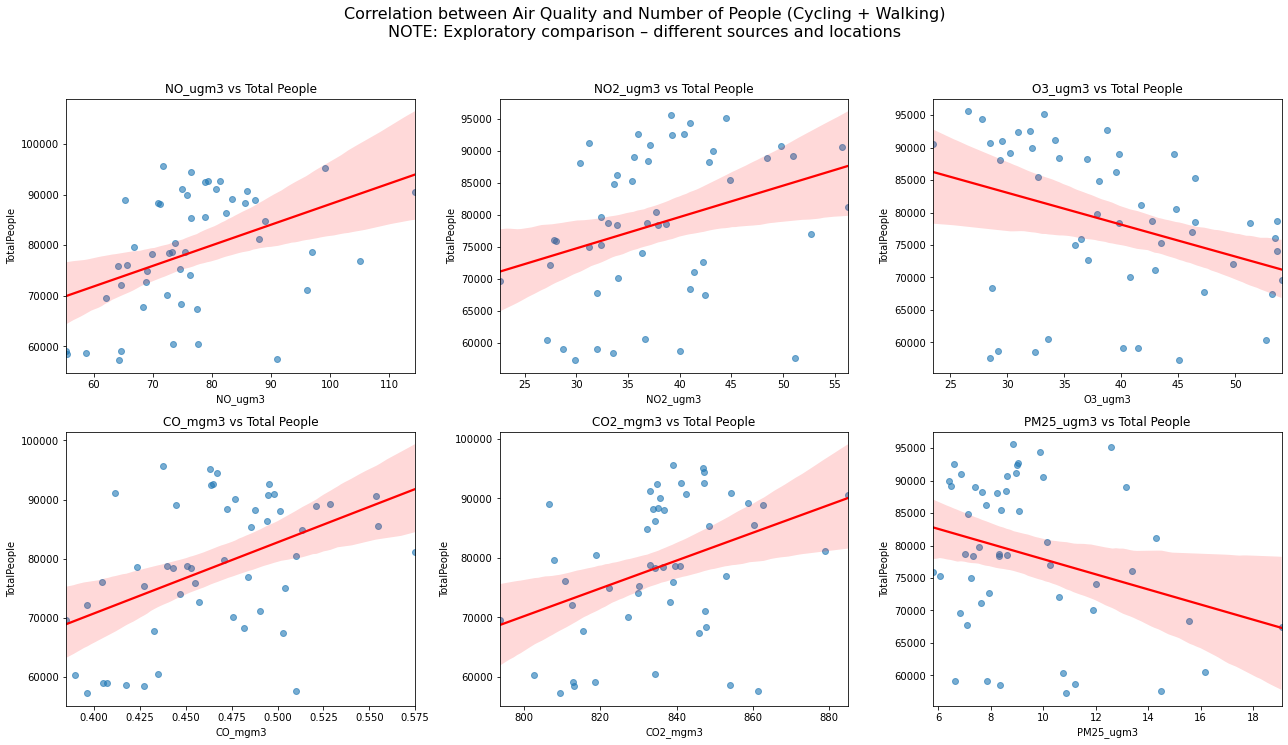

In [ ]:
# Plot scatter plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=merged,
        x=pollutant,
        y='TotalPeople',
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'{pollutant} vs Total People')

plt.suptitle('Correlation between Air Quality and Number of People (Cycling + Walking)\nNOTE: Exploratory comparison – different sources and locations', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()